
Random Forest Reliability Assessment

>>> Iteration 1/5 <<<
Iteration 1 Summary:
MAE: 0.10 ± 0.07
R²: 0.81 ± 0.27

>>> Iteration 2/5 <<<
Iteration 2 Summary:
MAE: 0.11 ± 0.10
R²: 0.82 ± 0.15

>>> Iteration 3/5 <<<
Iteration 3 Summary:
MAE: 0.10 ± 0.07
R²: 0.73 ± 0.36

>>> Iteration 4/5 <<<
Iteration 4 Summary:
MAE: 0.11 ± 0.11
R²: 0.80 ± 0.17

>>> Iteration 5/5 <<<
Iteration 5 Summary:
MAE: 0.11 ± 0.09
R²: 0.76 ± 0.18


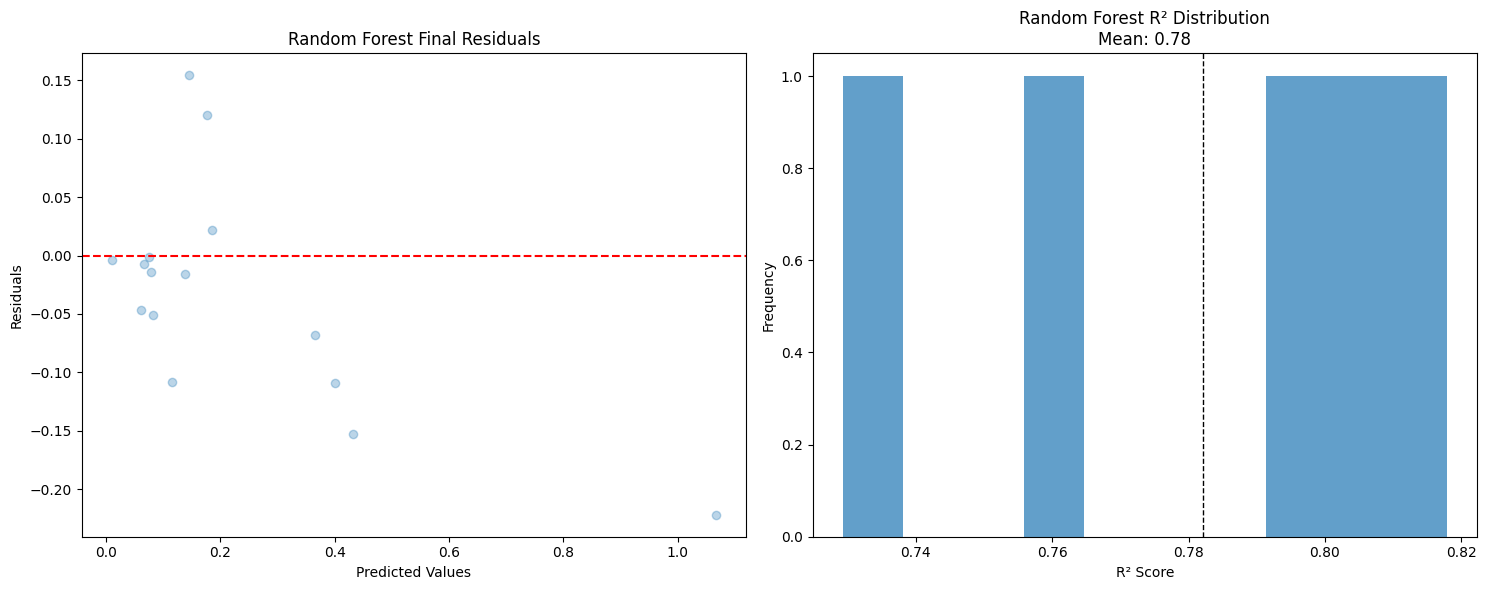


CatBoost Reliability Assessment

>>> Iteration 1/5 <<<


KeyboardInterrupt: 

In [2]:
# Install required packages if missing
# !pip install catboost category_encoders scikit-learn pandas numpy matplotlib openpyxl

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, RandomizedSearchCV, learning_curve, RepeatedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

# --------------------------
# DATA IMPORT AND CLEANING (WITH LOG TRANSFORM)
# --------------------------
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part'
    
])
df['Raw Material'] = df['Raw Material'].str.title()

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 
    'Thickness (mm)', 'Part Net Weight (g)', 
    'Surface Treatment cost (€/Part)','Final Raw Material cost (€/Part)','Heat Treatment cost (€/Part)'
]
cat_cols = [
    'Production', 'Raw Material', 'Heat treatment', 
    'Raw Material Designation', 'Surface Treatment'
]

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')

TARGET = 'Total cost with amortization (€/part)'
X = df.drop(TARGET, axis=1)
y_original = df[TARGET].copy()
y = np.log1p(y_original)  # Log-transform the target

# --------------------------
# PREPROCESSING PIPELINES
# --------------------------
general_preprocessor = ColumnTransformer([
    ('cat', Pipeline([
        ('encoder', TargetEncoder()), 
        ('scaler', RobustScaler())
    ]), cat_cols),
    ('num', RobustScaler(), num_cols)
])

catboost_preprocessor = ColumnTransformer([
    ('num', RobustScaler(), num_cols)],
    remainder='passthrough'
)

# --------------------------
# MODEL CONFIGURATIONS 
# --------------------------
models = {
    'Random Forest': (RandomForestRegressor(), {
        'model__n_estimators': [50, 100, 150],
        'model__max_depth': [3, 5, None],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['sqrt', 'log2']
    }),
    'CatBoost': (CatBoostRegressor(verbose=0), {
        'model__iterations': [100, 200],
        'model__depth': [3, 4, 6],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__l2_leaf_reg': [1, 3, 5],
        'model__cat_features': [list(range(len(num_cols), len(num_cols)+len(cat_cols)))]
    })
}

# --------------------------
# RELIABILITY EVALUATION FRAMEWORK
# --------------------------
NUM_ITERATIONS = 5
results = []

for name, (model, params) in models.items():
    print(f"\n{'='*40}\n{name} Reliability Assessment\n{'='*40}")
    
    iteration_metrics = {
        'MAE': [], 'RMSE': [], 'R2': [], 'Train R2': []
    }
    
    for iteration in range(NUM_ITERATIONS):
        print(f"\n>>> Iteration {iteration+1}/{NUM_ITERATIONS} <<<")
        current_seed = 42 + iteration
        
        # Pipeline setup with seed control
        if name == 'CatBoost':
            pipeline = Pipeline([
                ('preprocessor', catboost_preprocessor),
                ('model', model.set_params(random_seed=current_seed))
            ])
        else:
            pipeline = Pipeline([
                ('preprocessor', general_preprocessor),
                ('model', model.set_params(random_state=current_seed))
            ])
        
        # Enhanced hyperparameter search
        search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=params,
            n_iter=50 if name == 'CatBoost' else 30,
            cv=RepeatedKFold(n_splits=5, n_repeats=2, random_state=current_seed),
            scoring='neg_mean_absolute_error',
            n_jobs=-1,
            random_state=current_seed
        )
        search.fit(X, y)
        
        # Robust validation with repeated splits
        rkf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=current_seed)
        mae_scores, rmse_scores, r2_scores = [], [], []
        train_r2_scores = []
        
        for train_idx, test_idx in rkf.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train = y.iloc[train_idx]
            y_test_original = y_original.iloc[test_idx]
            
            search.best_estimator_.fit(X_train, y_train)
            log_y_pred = search.best_estimator_.predict(X_test)
            y_pred = np.expm1(log_y_pred)
            
            # Training metrics
            log_train_pred = search.best_estimator_.predict(X_train)
            train_pred = np.expm1(log_train_pred)
            train_r2 = r2_score(y_original.iloc[train_idx], train_pred)
            train_r2_scores.append(train_r2)
            
            # Test metrics
            mae_scores.append(mean_absolute_error(y_test_original, y_pred))
            rmse_scores.append(np.sqrt(mean_squared_error(y_test_original, y_pred)))
            r2_scores.append(r2_score(y_test_original, y_pred))
        
        # Store iteration results
        iteration_metrics['MAE'].append(np.mean(mae_scores))
        iteration_metrics['RMSE'].append(np.mean(rmse_scores))
        iteration_metrics['R2'].append(np.mean(r2_scores))
        iteration_metrics['Train R2'].append(np.mean(train_r2_scores))
        
        # Per-iteration diagnostics
        print(f"Iteration {iteration+1} Summary:")
        print(f"MAE: {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}")
        print(f"R²: {np.mean(r2_scores):.2f} ± {np.std(r2_scores):.2f}")
    
    # Aggregate results across iterations
    results.append({
        'Model': name,
        'MAE': f"{np.mean(iteration_metrics['MAE']):.2f} ± {np.std(iteration_metrics['MAE']):.2f}",
        'RMSE': f"{np.mean(iteration_metrics['RMSE']):.2f} ± {np.std(iteration_metrics['RMSE']):.2f}",
        'R2': f"{np.mean(iteration_metrics['R2']):.2f} ± {np.std(iteration_metrics['R2']):.2f}",
        'Train R2': f"{np.mean(iteration_metrics['Train R2']):.2f} ± {np.std(iteration_metrics['Train R2']):.2f}"
    })
    
    # Visualization (1 set per model)
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    # Residual Plot
    ax[0].scatter(y_pred, y_test_original - y_pred, alpha=0.3)
    ax[0].axhline(0, color='red', linestyle='--')
    ax[0].set_title(f'{name} Final Residuals')
    ax[0].set_xlabel('Predicted Values')
    ax[0].set_ylabel('Residuals')
    
    # R² Distribution
    ax[1].hist(iteration_metrics['R2'], bins=10, alpha=0.7)
    ax[1].axvline(np.mean(iteration_metrics['R2']), color='k', linestyle='dashed', linewidth=1)
    ax[1].set_title(f'{name} R² Distribution\nMean: {np.mean(iteration_metrics["R2"]):.2f}')
    ax[1].set_xlabel('R² Score')
    ax[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# --------------------------
# FINAL RESULTS
# --------------------------
results_df = pd.DataFrame(results)
print("\n\n=== Final Reliability Assessment ===")
print(results_df.to_string(index=False))


# Class Balancing

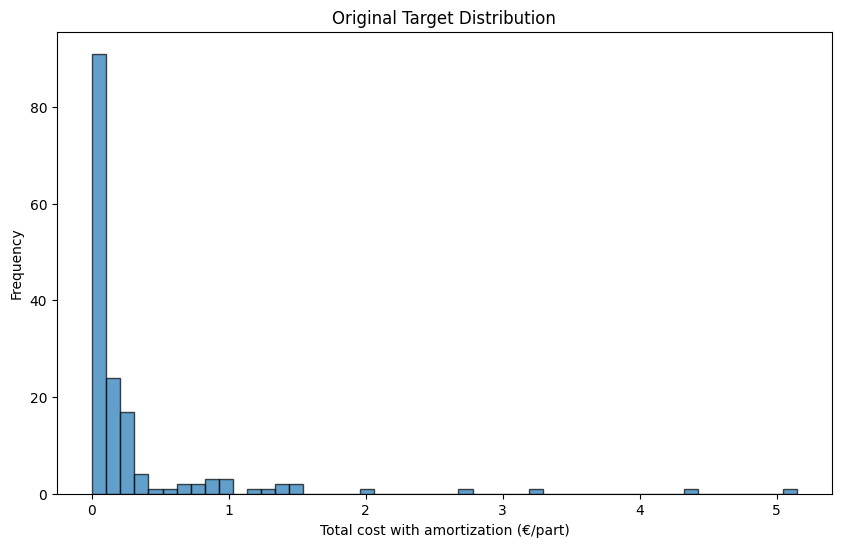


Random Forest Reliability Assessment

>>> Iteration 1/5 <<<
Iteration 1 Summary:
MAE: 0.12 ± 0.09
R²: 0.72 ± 0.34

>>> Iteration 2/5 <<<
Iteration 2 Summary:
MAE: 0.12 ± 0.11
R²: 0.75 ± 0.23

>>> Iteration 3/5 <<<
Iteration 3 Summary:
MAE: 0.12 ± 0.09
R²: 0.64 ± 0.44

>>> Iteration 4/5 <<<
Iteration 4 Summary:
MAE: 0.13 ± 0.12
R²: 0.71 ± 0.32

>>> Iteration 5/5 <<<
Iteration 5 Summary:
MAE: 0.13 ± 0.11
R²: 0.64 ± 0.45


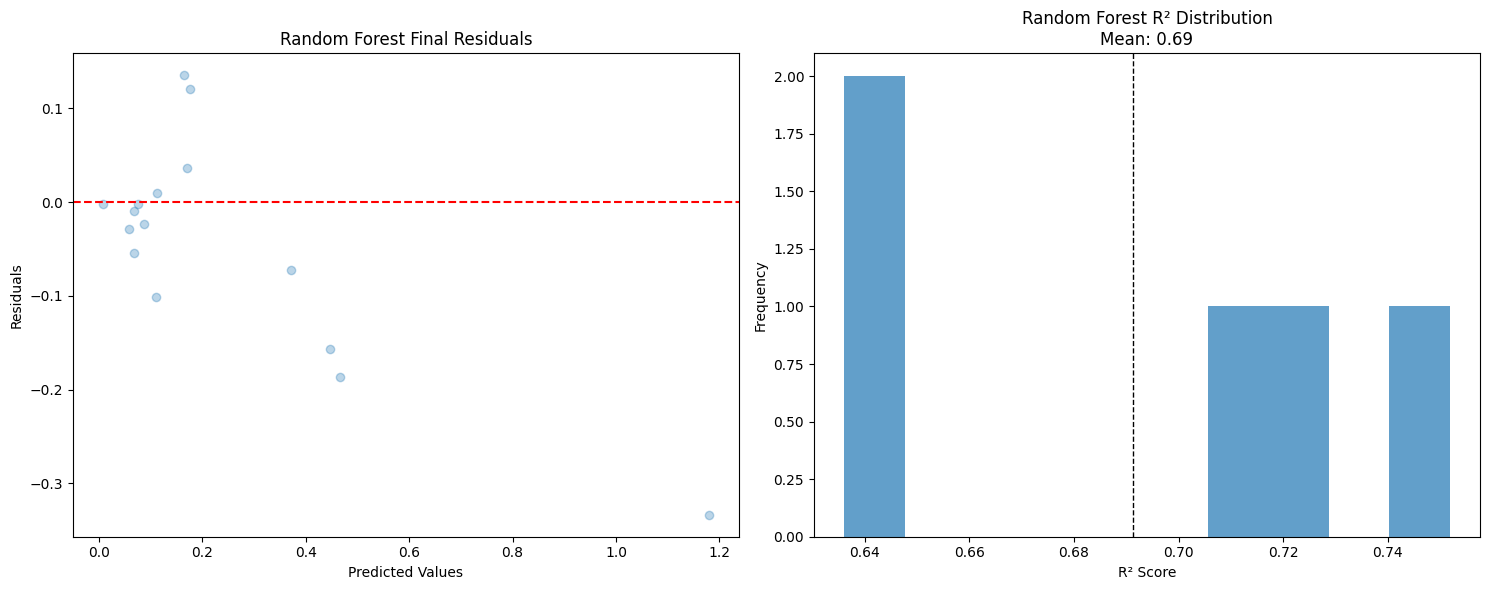


CatBoost Reliability Assessment

>>> Iteration 1/5 <<<
Iteration 1 Summary:
MAE: 0.08 ± 0.06
R²: 0.85 ± 0.17

>>> Iteration 2/5 <<<
Iteration 2 Summary:
MAE: 0.10 ± 0.09
R²: 0.83 ± 0.16

>>> Iteration 3/5 <<<
Iteration 3 Summary:
MAE: 0.08 ± 0.07
R²: 0.84 ± 0.13

>>> Iteration 4/5 <<<
Iteration 4 Summary:
MAE: 0.09 ± 0.10
R²: 0.82 ± 0.16

>>> Iteration 5/5 <<<
Iteration 5 Summary:
MAE: 0.11 ± 0.09
R²: 0.77 ± 0.19


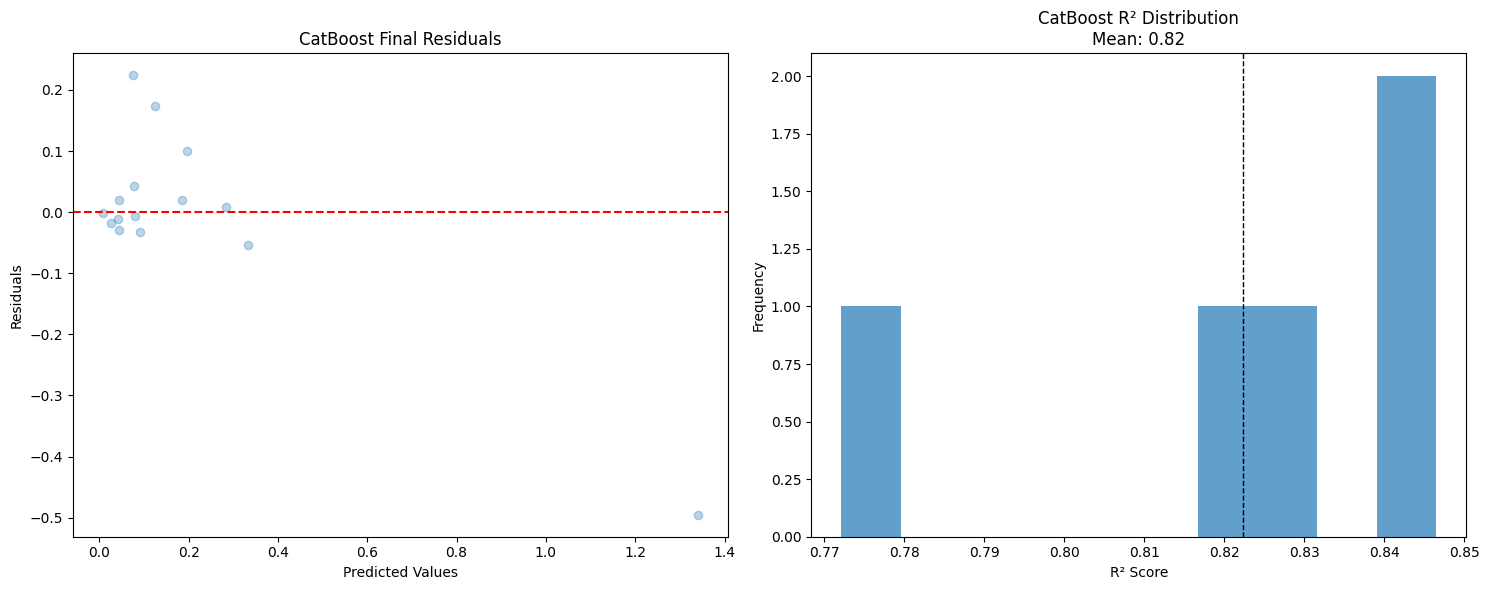



=== Final Reliability Assessment ===
        Model         MAE        RMSE          R2    Train R2
Random Forest 0.12 ± 0.01 0.27 ± 0.02 0.69 ± 0.05 0.94 ± 0.00
     CatBoost 0.09 ± 0.01 0.20 ± 0.02 0.82 ± 0.03 0.97 ± 0.01


In [ ]:
# Install required packages if missing
# !pip install catboost category_encoders scikit-learn pandas numpy matplotlib openpyxl

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, RandomizedSearchCV, learning_curve, RepeatedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

# --------------------------
# WEIGHT GENERATION FUNCTION
# --------------------------
def generate_sample_weights(y_original, n_bins=10):
    """Create inverse frequency weights for regression targets"""
    bins = np.quantile(y_original, np.linspace(0, 1, n_bins))
    bin_indices = np.digitize(y_original, bins)
    bin_counts = np.bincount(bin_indices)
    bin_weights = 1 / (bin_counts + 1e-8)
    weights = bin_weights[bin_indices]
    return weights / np.mean(weights)

# --------------------------
# DATA IMPORT AND CLEANING (WITH LOG TRANSFORM)
# --------------------------
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
    'Heat Treatment cost (€/Part)'
])
df['Raw Material'] = df['Raw Material'].str.title()

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 
    'Thickness (mm)', 'Part Net Weight (g)', 
    'Surface Treatment cost (€/Part)'
]
cat_cols = [
    'Production', 'Raw Material', 
    'Raw Material Designation', 'Surface Treatment'
]

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')

TARGET = 'Total cost with amortization (€/part)'
X = df.drop(TARGET, axis=1)
y_original = df[TARGET].copy()
y = np.log1p(y_original)  # Log-transform the target

# Target distribution visualization
plt.figure(figsize=(10, 6))
plt.hist(y_original, bins=50, edgecolor='k', alpha=0.7)
plt.title('Original Target Distribution')
plt.xlabel('Total cost with amortization (€/part)')
plt.ylabel('Frequency')
plt.show()

# --------------------------
# PREPROCESSING PIPELINES
# --------------------------
general_preprocessor = ColumnTransformer([
    ('cat', Pipeline([
        ('encoder', TargetEncoder()), 
        ('scaler', RobustScaler())
    ]), cat_cols),
    ('num', RobustScaler(), num_cols)
])

catboost_preprocessor = ColumnTransformer([
    ('num', RobustScaler(), num_cols)],
    remainder='passthrough'
)

# --------------------------
# ENHANCED MODEL CONFIGURATIONS 
# --------------------------
models = {
    'Random Forest': (RandomForestRegressor(), {
        'model__n_estimators': [50, 100, 150],
        'model__max_depth': [3, 5, None],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['sqrt', 'log2']
    }),
    'CatBoost': (CatBoostRegressor(verbose=0), {
        'model__iterations': [200, 300],
        'model__depth': [4, 6, 8],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__l2_leaf_reg': [1, 3, 5],
        'model__min_data_in_leaf': [1, 3, 5],
        'model__loss_function': ['RMSE', 'Quantile:alpha=0.5'],
        'model__cat_features': [list(range(len(num_cols), len(num_cols)+len(cat_cols)))],
        'model__border_count': [254]  # Better for numerical features
    })
}

# --------------------------
# RELIABILITY EVALUATION FRAMEWORK
# --------------------------
NUM_ITERATIONS = 5
results = []

for name, (model, params) in models.items():
    print(f"\n{'='*40}\n{name} Reliability Assessment\n{'='*40}")
    
    iteration_metrics = {
        'MAE': [], 'RMSE': [], 'R2': [], 'Train R2': []
    }
    
    for iteration in range(NUM_ITERATIONS):
        print(f"\n>>> Iteration {iteration+1}/{NUM_ITERATIONS} <<<")
        current_seed = 42 + iteration
        
        if name == 'CatBoost':
            pipeline = Pipeline([
                ('preprocessor', catboost_preprocessor),
                ('model', model.set_params(random_seed=current_seed))
            ])
        else:
            pipeline = Pipeline([
                ('preprocessor', general_preprocessor),
                ('model', model.set_params(random_state=current_seed))
            ])
        
        search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=params,
            n_iter=50 if name == 'CatBoost' else 30,
            cv=RepeatedKFold(n_splits=5, n_repeats=2, random_state=current_seed),
            scoring='neg_mean_absolute_error',
            n_jobs=-1,
            random_state=current_seed
        )
        search.fit(X, y)
        
        rkf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=current_seed)
        mae_scores, rmse_scores, r2_scores = [], [], []
        train_r2_scores = []
        
        for train_idx, test_idx in rkf.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train = y.iloc[train_idx]
            y_test_original = y_original.iloc[test_idx]
            
            # Generate sample weights for this fold
            y_train_original = y_original.iloc[train_idx]
            sample_weights = generate_sample_weights(y_train_original)
            
            # Train with sample weights
            search.best_estimator_.fit(
                X_train, y_train,
                model__sample_weight=sample_weights
            )
            
            # Predictions and metrics
            log_y_pred = search.best_estimator_.predict(X_test)
            y_pred = np.expm1(log_y_pred)
            
            # Training metrics
            log_train_pred = search.best_estimator_.predict(X_train)
            train_pred = np.expm1(log_train_pred)
            train_r2 = r2_score(y_original.iloc[train_idx], train_pred)
            train_r2_scores.append(train_r2)
            
            # Test metrics
            mae_scores.append(mean_absolute_error(y_test_original, y_pred))
            rmse_scores.append(np.sqrt(mean_squared_error(y_test_original, y_pred)))
            r2_scores.append(r2_score(y_test_original, y_pred))
        
        iteration_metrics['MAE'].append(np.mean(mae_scores))
        iteration_metrics['RMSE'].append(np.mean(rmse_scores))
        iteration_metrics['R2'].append(np.mean(r2_scores))
        iteration_metrics['Train R2'].append(np.mean(train_r2_scores))
        
        print(f"Iteration {iteration+1} Summary:")
        print(f"MAE: {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}")
        print(f"R²: {np.mean(r2_scores):.2f} ± {np.std(r2_scores):.2f}")
    
    results.append({
        'Model': name,
        'MAE': f"{np.mean(iteration_metrics['MAE']):.2f} ± {np.std(iteration_metrics['MAE']):.2f}",
        'RMSE': f"{np.mean(iteration_metrics['RMSE']):.2f} ± {np.std(iteration_metrics['RMSE']):.2f}",
        'R2': f"{np.mean(iteration_metrics['R2']):.2f} ± {np.std(iteration_metrics['R2']):.2f}",
        'Train R2': f"{np.mean(iteration_metrics['Train R2']):.2f} ± {np.std(iteration_metrics['Train R2']):.2f}"
    })
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    ax[0].scatter(y_pred, y_test_original - y_pred, alpha=0.3)
    ax[0].axhline(0, color='red', linestyle='--')
    ax[0].set_title(f'{name} Final Residuals')
    ax[0].set_xlabel('Predicted Values')
    ax[0].set_ylabel('Residuals')
    
    ax[1].hist(iteration_metrics['R2'], bins=10, alpha=0.7)
    ax[1].axvline(np.mean(iteration_metrics['R2']), color='k', linestyle='dashed', linewidth=1)
    ax[1].set_title(f'{name} R² Distribution\nMean: {np.mean(iteration_metrics["R2"]):.2f}')
    ax[1].set_xlabel('R² Score')
    ax[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# --------------------------
# FINAL RESULTS
# --------------------------
results_df = pd.DataFrame(results)
print("\n\n=== Final Reliability Assessment ===")
print(results_df.to_string(index=False))
